# Introduction:

This tutorial demonstrates a 1-D AutoEncoder implemented in Pytorch. The contents are for educational purpose. 

This tutorial was accomplished with the help of the following references. 

# References:
[1] Building your first Variational Autoencoder with PyTorch (https://www.youtube.com/watch?v=IQpP_cH8rrA&t=11s)

[2] Autoencoder In PyTorch - Theory & Implementation, incluidng 2D CNN Autoencoder (https://www.youtube.com/watch?v=zp8clK9yCro)

[3] Creating ANN with Pytorch On Pima Diabetes Dataset & Training On GPU
(https://github.com/krishnaik06/Pytorch-Tutorial/blob/master/Tutorial%206-%20Creating%20ANN%20with%20Pytorch%20On%20Pima%20Diabetes%20Dataset%20%26%20Training%20On%20GPU.ipynb)

[4] https://www.jeremyjordan.me/

[5] How To Use GPU with PyTorch (https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk#:~:text=The%20easiest%20way%20to%20check,the%20Nvidia%20driver%20correctly%20installed)

In [1]:
# allow modules automatically reloaded when this notebook is rerun
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Chang' -v -p torch

%matplotlib inline

Author: Chang

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

torch: 2.0.1



# Import modules

In [2]:
# import modules
import torch
import matplotlib.pyplot as plt

# import my custom modules
import utils

# Get MNIST Handwritten Digits data

In [3]:
# get the MNIST Dataset
mnist_data = utils.get_mnist_data()

# DataLoader is used to load the dataset for training
data_loader = torch.utils.data.DataLoader(
    dataset = mnist_data,
    batch_size = 64,
	shuffle = True
)

In [4]:
# check data range: we want the data values to range from 0 to 1
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# Determine the computing device as CPU or GPU 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The computing wil performed on: {device}")

The computing wil performed on: cuda:0


# Define AutoEncoder1D
As the model name suggests, this autoencoder is working on 1D. In other words, any data with dimensionality more than 1 must be converted into a single vector before being fed into this autoencoder.

In [6]:
# Creating a PyTorch class
class AutoEncoder1D(torch.nn.Module):
	def __init__(self):
		super().__init__()

		# Building an encoder reducing dimension from 784 to 4. 
        # Each Linear layer is followed by a Relu activation function.
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 16),
			torch.nn.ReLU(),
			torch.nn.Linear(16, 4) # output size n x 4
		)
        
		# Building a decoder expanding dimension from 4 to 784.
        # Note that the last Linear layer is a Sigmoid activation function that outputs values between 0 and 1
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(4, 16),
			torch.nn.ReLU(),
			torch.nn.Linear(16, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28 * 28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


# Prepare for training

In [7]:
# Model Initialization
model = AutoEncoder1D()

# send the model to CPU/GPU; if GPU is used for sure, the command can be: model = model.cuda()
model = model.to(device)

# objective function to be optimized:  MSE Loss function
cost_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(
    model.parameters(),
	lr = 1e-3,
	weight_decay = 1e-5
)

# Perform training
Note that this step may take a while if running on CPU and/or if the RAM is small

In [8]:
num_epochs = 10
outputs = [0] * num_epochs
losses = torch.empty(num_epochs)
model.train()
for epoch in range(num_epochs):
    curr_losses = []
    for (img, _) in data_loader:
        # Reshaping the image to a 1D vector
        img = img.reshape(-1, 28*28)
        
        # Transfer the image data to computing device; if GPU is used for sure, the command can be: img = img.cuda()
        img = img.to(device)
        
        # Output generated by the Autoencoder
        reconstructed = model(img)
        
        # Calculating the loss function
        loss = cost_function(reconstructed, img)
        
        # The gradients are reset to zero, and then being computed.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # .step() performs parameter update
        
        # Storing the losses for visualization
        curr_losses.append(loss)

    outputs[epoch] = (img, reconstructed)        
    losses[epoch] = torch.mean(torch.stack(curr_losses))
    print(f"Epoch {epoch}, Loss: {losses[epoch].item(): .4f}")

Epoch 0, Loss:  0.0595
Epoch 1, Loss:  0.0447
Epoch 2, Loss:  0.0406
Epoch 3, Loss:  0.0377
Epoch 4, Loss:  0.0355
Epoch 5, Loss:  0.0342
Epoch 6, Loss:  0.0334
Epoch 7, Loss:  0.0328
Epoch 8, Loss:  0.0324
Epoch 9, Loss:  0.0320


# Visualize results

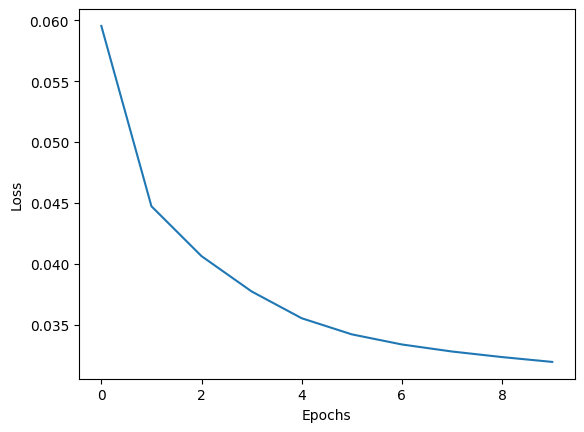

In [9]:
# plot the losses
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([lo.cpu().detach().numpy() for lo in losses])

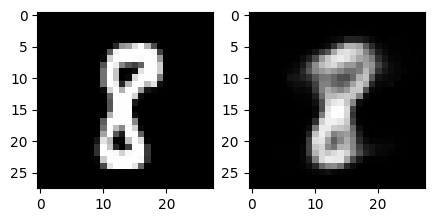

In [10]:
# plot last example of original and reconstructed images
plt.figure(figsize=(5, 10))
plt.gray()
for i, item in enumerate(img.cpu().detach().numpy()):
    # Reshape the array for plotting
    item = item.reshape(-1, 28, 28)
    plt.subplot(1,2,1)
    plt.imshow(item[0])

for i, item in enumerate(reconstructed.cpu().detach().numpy()):
    item = item.reshape(-1, 28, 28)
    plt.subplot(1,2,2)
    plt.imshow(item[0])